# Reaction commercially available

In drug discovery, the lead optimization step often involves creating analogues of a hit (a promising compound which produces a desired result in an assay) to optimize selectivity and minimize toxicity. Because it is typically easier to chemically modify the periphery of the molecule (for example the functional groups) than the scaffold, it is helpful to compare the groups off of the common scaffold. This utility function uses RDKit to find the maximum common substructure (MCS) between a set of molecules, then show the groups off of that MCS.

In a previous blog post, I [found and highlighted the maximum common substructure (MCS) between a set of molecules]({% post_url 2022-10-09-RDKit-find-and-highlight-the-maximum-common-substructure-between-molecules %}) by creating a function `SmilesMCStoGridImage` using RDKit. This post takes it a step further by optionally identifying and showing the groups off the MCS. These might be R groups off a core scaffold.

Here's an example, annotated to explain the grid arrangement:

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2022-12-25-RDKit-Find-Groups-Off-Common-Core.ipynb)*

To show the groups off of the MCS, the grid of molecular images is two-dimensional:
- The first row is the MCS (as first SMARTS match, then as a molecule referred to as the core)
- Each subsequent row represents an input molecule
    - The first item in the row is the input molecule
    - Each subsequent item is a group off of the MCS, sorted by the core atom the group is attached to

The key RDKit commands it uses are:
- [`ReplaceCore`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.ReplaceCore) to mask out the MCS in each molecule
- [`GetMolFrags`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.GetMolFrags) to get the molecular fragments (groups) off of the MCS
- [`FindMCS`](https://www.rdkit.org/docs/source/rdkit.Chem.rdFMCS.html) to find the maximum common substructure (SMARTS string)
- [`MolFromSmarts`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html) to generate a molecule corresponding to the maximum common substructure
- [`GenerateDepictionMatching2DStructure`](http://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html) to align the matching substructure
- [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) to draw the grid of the MCS, the molecules with that MCS highlighted, and the groups off of the MCS for each molecule

You can think of the core as the materialized MCS. That is, the MCS is a substructure match (SMARTS), and the core is a structure (SMILES). For example, on the right side of the MCS, off the aromatic ring is a nitrogen atom, N. The analogous part of the core materializes that nitrogen in the simplest possible way, into an amine group, NH<sub>2</sub>.

In [95]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
!pip install aiohttp
!pip install codetiming

In [35]:
import asyncio

import aiohttp
import rdkit
from codetiming import Timer
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions

In [36]:
class Reactant():
    """Define a reactant's commercial availability."""

    def __init__(self, smiles):
        """
        Construct a Reactant object to store the commercial availability of a reactant

        :param smiles: SMILES string representing a molecule
        """
        self.smiles = smiles
        self.mol = Chem.MolFromSmiles(smiles)

        @property
        def in_pubchem(self):
            return self._in_pubchem

        @in_pubchem.setter
        def in_pubchem(self, value):
            self._in_pubchem = value

        @property
        def pubchem_cid(self):
            return self._pubchem_cid

        @pubchem_cid.setter
        def pubchem_cid(self, value):
            self._pubchem_cid = value

        @property
        def commercially_available(self):
            return self._commercially_available

        @commercially_available.setter
        def commercially_available(self, value):
            self._commercially_available = value

        @property
        def pubchem_page(self):
            return self._pubchem_page

        @pubchem_page.setter
        def pubchem_page(self, value):
            self._pubchem_page = value

        def __repr__(self):
            str_print = f"SMILES {self.smiles}"
            str_print += f", in_pubchem = {self.in_pubchem}"
            str_print += f", pubchem_cid = {self.pubchem_cid}"
            str_print += f", in_pubchem = {self.in_pubchem}"
            str_print += f", commercially_available = {self.commercially_available}"
            str_print += f", pubchem_page = {self.pubchem_page}"
            return str_print

        def __str__(self):
            return __repr__(self)

In [37]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    flat_list = []
    for row in twoD_list:
        for item in row:
            flat_list += [item]
    return flat_list

def longest_row(twoD_list: list[list]) -> int:
    return max(len(row) for row in twoD_list)

def pad_rows(twoD_list: list[list], row_length: int, filler = "") -> list[list]:
    for row in twoD_list:
        padding = row_length - len(row)
        row += [filler] * padding
    return twoD_list

def label_zero_dummy_atom(frag: str) -> str:
    # Search for *l where l is a letter (atomic symbol)
    # Example inputs:
    #   Has dummy atom:   '[2*]C' stays the same
    #   Lacks dummy atom: '*CCC' -> '[0*]CCC', so want to replace '*' with '[0*]'

    # Search for pattern *l; returns an object if found, None if not found
    missing_dummy_atom = re.search('\*[a-zA-Z]', frag)

    if missing_dummy_atom:
        return frag.replace('*', '[0*]', 1)
    else:
        return frag

def extract_dummy_atom_number(frag: str) -> int:
    # Extract the dummy atom number from a fragment string
    # Examples: '[2*]C' -> 2, '[12*]C' -> 12
    bracket_n_star = re.search("\[\d+\*", frag)
    return int(bracket_n_star.group()[1:-1])

In [38]:
class Reaction():
    """Define a reaction's target, type, reactants, and commercial of reactants."""

    def __init__(self, target, reaction_smarts, name):
        """
        Construct a Reaction object 

        :param target: The molecule to synthesize as a SMILES string
        :param reaction_smarts: The reaction SMARTS as e.g. reactant1.reactant2>>product
        :param name: Name of the reaction, for user's information
        """
        self.target = target
        self.reaction_smarts = reaction_smarts
        self.name = name
        self.target_mol = Chem.MolFromSmiles(self.target)
        self.reactants = dict()

        @property
        def reactants(self):
            return self._reactants

        @reactants.setter
        def reactants(self, value):
            self._reactants = value

        @property
        def reactants_commercially_available(self):
            return self._reactants_commercially_available

    def tally_all_reactants_commercially_available(self):
        """
        Given the commercial availability of each reactant, determine whether they are all available
        """
        for reactant in self.reactants:
            if not self.reactants[reactant].commercially_available:
                self._reactants_commercially_available = False
                return False
        self._reactants_commercially_available = True
        return True

In [46]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    return [item for sublist in twoD_list for item in sublist]
    
def longest_row(twoD_list: list[list]) -> int:
    return max(len(row) for row in twoD_list)

def pad_rows(twoD_list: list[list], row_length: int, filler = "") -> list[list]:
    for row in twoD_list:
        padding = row_length - len(row)
        row += [filler] * padding
    return twoD_list

In [39]:
def reverse_reaction(rxn_fwd):
    """
    Reverse an RDKit reaction
    Code adapted from https://www.rdkit.org/docs/Cookbook.html#reversing-reactions by Greg Landrum

    :param rxn_fwd: forward chemical reaction rdkit.Chem.rdChemReactions.ChemicalReaction
    :returns: reverse chemical reaction rdkit.Chem.rdChemReactions.ChemicalReaction
    """

    rxn_rev = Chem.ChemicalReaction()
    for i in range(rxn_fwd.GetNumReactantTemplates()):
        rxn_rev.AddProductTemplate(rxn_fwd.GetReactantTemplate(i))
    for i in range(rxn_fwd.GetNumProductTemplates()):
        rxn_rev.AddReactantTemplate(rxn_fwd.GetProductTemplate(i))
    rxn_rev.Initialize()
    return rxn_rev

In [40]:
async def is_commercially_available(work_queue):
    """
    Asynchronously check the availability of a queue of SMILES strings (chemicals) in PubChem
    Based on https://realpython.com/python-async-features/#asynchronous-non-blocking-http-calls

    :param work_queue: A queue where each item is a SMILES string (representing a molecule)
    :returns: Class Reactant object
    """

    async with aiohttp.ClientSession() as session:
        while not work_queue.empty():
            smiles = await work_queue.get()
            # Create Reactant object, which will be populated during this function
            reactant = Reactant(smiles)

            timer = Timer(text=f"{{:.2f}}s for {smiles} PubChem API call(s)")

            # print(f"Task {smiles} getting URL")
            timer.start()
            get_cid_URL = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/cids/TXT"
            async with session.get(get_cid_URL, ssl=False) as response:
                get_cid_response = await response.text()
                cid = get_cid_response.strip("\n")
            if cid == '0':
                # print(f"Task {smiles}: No chemical in PubChem")
                reactant.in_pubchem = False
                reactant.commercially_available = False
                timer.stop()
                return reactant
            else:
                reactant.in_pubchem = True
                reactant.pubchem_page = f"https://pubchem.ncbi.nlm.nih.gov/compound/{cid}"

            compound_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/XML?heading=Chemical-Vendors"

            async with session.get(compound_url, ssl=False) as response:
                compound_vendors_response = await response.text()

            # print(f"  Task {smiles} cid: {cid}")
            # print(f"  Task {smiles} {compound_url=}, response = {compound_vendors_response[:70]}")
            timer.stop()

            if "<Message>No data found</Message>" in compound_vendors_response:
                reactant.commercially_available = False
            else:
                reactant.commercially_available = True
    return reactant

In [41]:
async def check_avail_smiles_set(smiles_set: set[str]) -> dict[str, object]:
    """
    Feed asynchronous queue to check the availability of several SMILES strings (chemicals) in PubChem
    Based on https://realpython.com/python-async-features/#asynchronous-non-blocking-http-calls

    :param smiles_set: Set of SMILES strings (representing molecules)
    :returns: dictionary of SMIILES:reactant pairs, where reactant is class Reactant
    """
    # Create the queue of work
    work_queue = asyncio.Queue()

    # Add each SMILES (molecule) to the work queue
    for smiles in smiles_set:
        await work_queue.put(smiles)

    # Determine commercial availability of each reactant
    with Timer(text="-----\n{:.2f}s total elapsed time for PubChem API calls"):
        tasks = [is_commercially_available(work_queue) for smiles in smiles_set]
        reactants = await asyncio.gather(*tasks)
    
    # Put reactants in dictionary of SMILES:Reaction object
    smiles_avail = dict()
    for index, reactant in enumerate(reactants):
        # print(f"Reactant {index}: {reactant}, {reactant.smiles}, in_pubchem: {reactant.in_pubchem}, commercially_available: {reactant.commercially_available}")
        smiles_avail[reactant.smiles] = reactant
    
    return smiles_avail

In [102]:
async def check_reactions(target_reaction_list: list[list[str, str, str]]):
    """
    Check whether the starting materials in a list of reactions are commercially available
    :param target_reaction_list: List of reactions in format [target (SMILES), reaction SMARTS, reaction name]
    """

    all_reactants_set = set()

    # List of Reaction objects
    reactions = []
    for target_reaction in target_reaction_list:
        reaction = Reaction(target_reaction[0], target_reaction[1], target_reaction[2])

        # Create forward reaction
        rxn_fwd = Chem.ReactionFromSmarts(reaction.reaction_smarts)

        # Reverse reaction
        rxn_rev = reverse_reaction(rxn_fwd)

        # Run reverse reaction to determine starting materials
        
        reactants = rxn_rev.RunReactants([reaction.target_mol])[0]
        for reactant in reactants:
            reactant_smiles = Chem.MolToSmiles(reactant)
            reaction.reactants[reactant_smiles] = None

        # Add starting materials to set of starting materials
        for reactant in reaction.reactants:
            all_reactants_set.add(reactant)
        
        reactions.append(reaction)

    # Check commercial availability of set of starting materials
    smiles_avail = await check_avail_smiles_set(all_reactants_set)

    print("\nAre starting materials commercially available for reaction -> target:")

    # reaction_reactants_avail format: [[reaction object 0, all reactants available], [reaction object 1, all reactants available],...]
    reaction_reactants_avail = [[]]
    for reaction in reactions:
        # Add information to Reaction objects
        for this_reactant in reaction.reactants:
            # Set value for key of reactant SMILES, to reactant object from smiles_avail
            reaction.reactants[this_reactant] = smiles_avail[this_reactant]
        reaction.tally_all_reactants_commercially_available()

        # Return results
        reaction_reactants_avail.append([reaction, reaction._reactants_commercially_available])
        print(f"{reaction.name} -> {reaction.target}: {reaction._reactants_commercially_available}")

    # Format molgrid output
    mols_2D = []
    legends_2D = []
    for reaction in reactions:
        mols_row = []
        legends_row = []
        mols_row.append(Chem.MolFromSmiles(reaction.target))
        legends_row.append(f"{reaction.name} target accessible: {reaction._reactants_commercially_available}")
        for reactant in reaction.reactants:
            mols_row.append(Chem.MolFromSmiles(reactant))
            legends_row.append(f"Reactant available: {reaction.reactants[reactant].commercially_available}")
        mols_2D.append(mols_row)
        legends_2D.append(legends_row)
    
    pad_rows(mols_2D, longest_row(mols_2D))
    pad_rows(legends_2D, longest_row(mols_2D))

    mols = flatten_twoD_list(mols_2D)
    legends = flatten_twoD_list(legends_2D)

    dwg = Draw.MolsToGridImage(mols=mols, legends=legends, molsPerRow=len(mols_2D[0]))
    return dwg
    # return reaction_reactants_avail

0.55s for O=CCC1C2C=CC(C2)N1CO PubChem API call(s)
0.61s for O=CCNc1ccccc1 PubChem API call(s)
0.64s for O=CC1CC(F)(F)C1 PubChem API call(s)
0.65s for NCCc1ccccc1 PubChem API call(s)
-----
0.66s total elapsed time for PubChem API calls

Are starting materials commercially available for reaction -> target:
Pictet-Spengler -> OCN1C2CC(C=C2)C1CC1NCCc2ccccc12: False
Pictet-Spengler -> c1ccc(NCC2NCCc3ccccc32)cc1: True
Pictet-Spengler -> FC1(F)CC(C2NCCc3ccccc32)C1: True


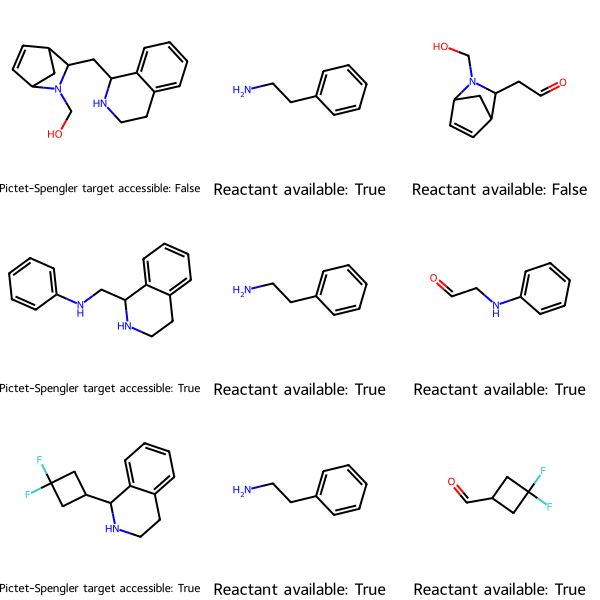

In [103]:
bicyclic_target = "OCN1C2CC(C=C2)C1CC1NCCc2ccccc12"
aniline_target = "c1ccc(NCC2NCCc3ccccc32)cc1"
cyclobutyl_target = "FC1(F)CC(C2NCCc3ccccc32)C1"

pictet_spengler_rxn = '[cH1:1]1:[c:2](-[CH2:7]-[CH2:8]-[NH2:9]):[c:3]:[c:4]:[c:5]:[c:6]:1.[#6:11]-[CH1;R0:10]=[OD1]>>[c:1]12:[c:2](-[CH2:7]-[CH2:8]-[NH1:9]-[C:10]-2(-[#6:11])):[c:3]:[c:4]:[c:5]:[c:6]:1'
pictet_spengler = [pictet_spengler_rxn, "Pictet-Spengler"]

# Reaction format: [target (SMILES), reaction SMARTS, reaction name]
rxn1 = [bicyclic_target] + pictet_spengler
rxn2 = [aniline_target] + pictet_spengler
rxn3 = [cyclobutyl_target] + pictet_spengler

rxns = [rxn1, rxn2, rxn3]
await check_reactions(rxns)

## Get Additional Data

If you want `SmilesMCStoGridImage` to return not just the grid image, but also the substructure match and molecule, plus the SMILES strings for the molecules and groups, and the core SMILES and molecule, set `verbose=True`:

In [ ]:
ms = {'c1c(O)cnc(N)c(NC(=O)(C))1': 'aldehyde off aromatic carbon', 'c1c(O)cnc(N(CCC))c1(C)': 'alkyl off amine'}
drawing, mcs_smarts, mcs_mol, mols_2D, core_smiles, core_mol = SmilesMCStoGridImage(ms, groups=True, verbose=True)

You then must explicitly call the image to draw it:

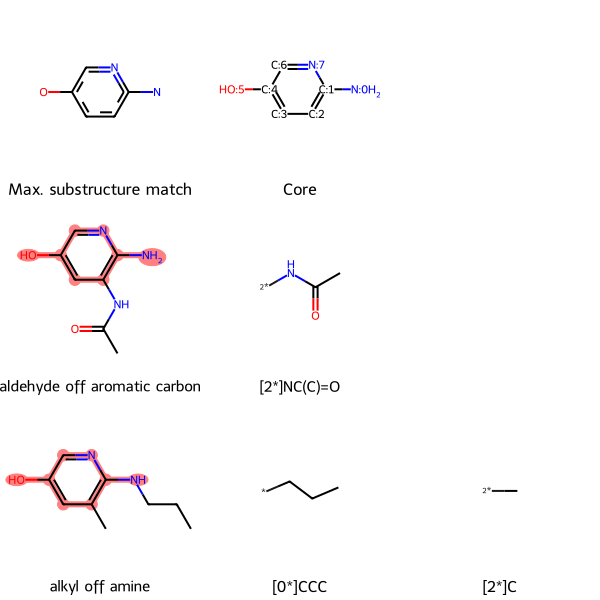

In [ ]:
drawing

`mcs_smarts` is the SMARTS match string for the maximum common substructure (MCS):

In [ ]:
mcs_smarts

'[#6]1:[#6](-[#8]):[#6]:[#7]:[#6](:[#6]:1)-[#7]'

`mcs_mol` is the molecular representation of that MCS:

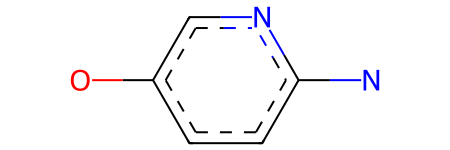

In [ ]:
mcs_mol

`mols_2D` is the nested list of input molecules and groups, where each sub-list represents an input molecule:

In [ ]:
mols_2D

[[<rdkit.Chem.rdchem.Mol at 0x16d8697e0>,

`core_smiles` is the SMILES string of the core that groups are off of:

In [ ]:
core_smiles

'Nc1ccc(O)cn1'

`core_mol` is the RDKit molecule for the core:

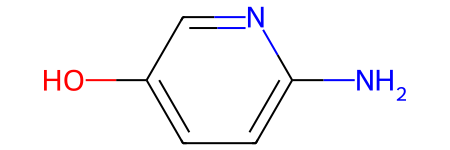

In [ ]:
core_mol

## Edge Case: There is No MCS

If you input a set of molecules that has no MCS, there is no core to locate groups off of, so `SmilesMCStoGridImage` will
- notify you and effectively ignore `groups=True`
- give the same result as if you had set `groups=False` or not included the `groups` flag at all (because its default is `False`):

There is no maximum common substructure (MCS), so groups off the MCS cannot be created. This output reflects groups=False. If you want to find groups, please ensure the set of molecules has an MCS.


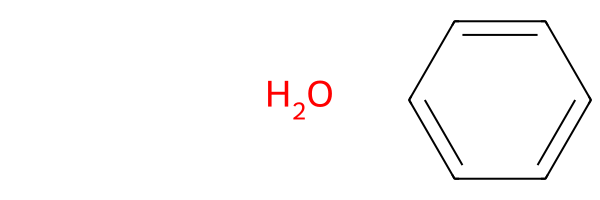

In [ ]:
SmilesMCStoGridImage(["O", "c1ccccc1"], groups=True)

### Using `groups` and `verbose` Equal `True` If There is No MCS

A call using `groups=True` and `verbose=True` when there is no MCS will not throw an exception; instead, `SmilesMCStoGridImage` will return values as if you had not set `groups=True`. As a result, you will not get a confusing exception about having an incorrect number of arguments to unpack.

In [ ]:
drawing_no_mcs, mcs_smarts_no_mcs, mcs_mol_no_mcs, mols_2D_no_mcs, core_smiles_no_mcs, core_mol_no_mcs = SmilesMCStoGridImage(["O", "c1ccccc1"], groups=True, verbose=True)

There is no maximum common substructure (MCS), so groups off the MCS cannot be created. This output reflects groups=False. If you want to find groups, please ensure the set of molecules has an MCS.


The drawing is the same as if you had not set `groups=True`:

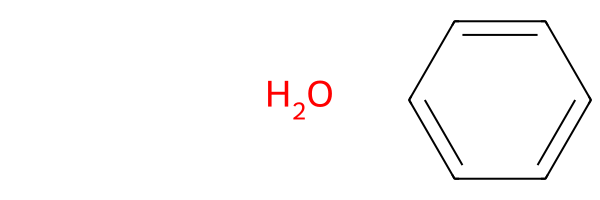

In [ ]:
drawing_no_mcs

You will get "empty" values for `mcs_smarts`, `mcs_mol`, `core_smiles`, and `core_mol`:

In [ ]:
mcs_smarts_no_mcs

''

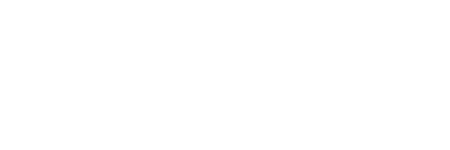

In [ ]:
mcs_mol_no_mcs

In [ ]:
core_smiles_no_mcs

''

In [ ]:
core_mol_no_mcs

And mols_2D will revert to the one-dimensional list of input molecules:

In [ ]:
mols_2D_no_mcs

## Notes

For more information about the other parameters in `SmilesMCStoGridImage`, refer to my original blog post [Find and Highlight the Maximum Common Substructure Between a Set of Molecules Using RDKit]({% post_url 2022-10-09-RDKit-find-and-highlight-the-maximum-common-substructure-between-molecules %})

Thanks to [Greg Landrum](https://github.com/greglandrum) for suggesting this scheme to find groups off of a common core, and to [Brian Kelley](https://github.com/bp-kelley) for clarifying the RDKit's atom numbering scheme for [`ReplaceCore`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.ReplaceCore).